In [79]:
#generic
import re
import os
import warnings
import logging 
from pathlib import Path
import importlib

import numpy as np
#ML 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

#RS 

import rasterio 
import geopandas as gpd 
#Project
from src.data.data_loader_rise import DataLoader
import functions

# 0. Functions

In [80]:

def agroeco_series(path,agvar,fromdate=0,todate=0): 
    '''
    Find the mean across entire malawi , and plot the time series. 
    Not using from and to for now. Get everything. 
    In the future, you can pass a geometry to only compute mean there; and an agg variable. 
    '''
    tiff_files = sorted([f for f in os.listdir(path) if f.endswith('.tif')])
    date_dict ={} # Keys are <<YEARDOY>> as int , values are aggregated spatially. 
    
    for file in tiff_files: 
        with rasterio.open(os.path.join(path, file)) as src: 
            band = src.read(1) # single band tiff
            meanval = np.nanmean(band)
        if(agvar=='Precipitation'): 
            date_dict[int(re.findall(r'v2\.0\.([0-9]*)',file)[0])] = meanval 
        elif(agvar=='Temperature'):
            date_dict[int(re.findall(r'agera5_([0-9]*)',file)[0])] = meanval 
    
        else:
            1/0,'Bug'
    return dict(sorted(date_dict.items()))

# 1. Preprocessing

In [81]:
AGROECO = True

In [82]:
## Inits 
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

main_path = Path(r'E:/PhD/Work/Malawi')
base_path = main_path / 'AK'

# main data paths
DATA_FILE_PATH = base_path / "data" / "train_ready" / "malawi_triplet_eos" / "train_rise" / "data.npy"
ID_FILE_PATH = base_path / "data" / "train_ready" / "malawi_triplet_eos" / "train_rise" / "ids.npy"
LABELS_FILE_PATH = base_path / "data" / "train_ready" / "malawi_triplet_eos" / "train_rise" / "labels.npy"
META_FILE_PATH = base_path / "data" / "train_ready" / "malawi_triplet_eos" / "train_rise" / "harmonized_malawi_3857_w_Id" / "harmonized_malawi_3857" / "harmonized_malawi_3857.shp"

if(AGROECO):
    META_FILE_PATH_REVISED = base_path/ "data"  / "train_ready" / "malawi_triplet_eos" / "train_rise" / "fafafafa.csv"
else:
    META_FILE_PATH_REVISED = base_path / "data"  / "train_ready" / "malawi_triplet_eos" / "train_rise" /"harmonized_malawi_3857_revised" / "harmonized_malawi_3857_revised.shp"

# Satellite band name and mapping to S1/S2 naming wherever possible
BAND_NAME_MAP = {
    'coastal_blue_median': 'COASTALBLUE',
    'blue_median': 'B2',
    'green_i_median': 'GREENI',
    'green_median': 'B3',
    'yellow_median': 'YELLOW',
    'red_median': 'B4',
    'rededge_median': 'REDEDGE',
    'nir_median': 'B8',
    'alpha_median': 'ALPHA'
}
BAND_NAMES = list(BAND_NAME_MAP.keys())
mask_value = 65535


In [83]:
data = np.load(DATA_FILE_PATH)
ids = np.load(ID_FILE_PATH)
labels = np.load(LABELS_FILE_PATH)
meta_o = gpd.read_file(META_FILE_PATH)
if(AGROECO):
    meta = pd.read_csv(META_FILE_PATH_REVISED)
else:
    meta = gpd.read_file(META_FILE_PATH_REVISED)

logger.info(f"Loaded train data {data.shape}")
logger.info(f"Loaded ids data {ids[0]}")
logger.info(f"Loaded labels data {labels[0]}")
logger.info(f"Value counts {meta['Intercrop'].value_counts()}")
logger.info("Loaded polygon data")

meta_selected = meta[meta['Source'] != 'CIMMYT'].reset_index(drop=True)
logger.info("Filtered data according to attribute")
logger.info(f"meta_selected head: {meta_selected.head()}")
logger.info(f"ids shape: {ids.shape}")
logger.info(f"data shape: {data.shape}")


data[data == 9999.0] = mask_value


logger.info("Masked no data values")



INFO:__main__:Loaded train data (636950, 29, 9)
INFO:__main__:Loaded ids data 0
INFO:__main__:Loaded labels data Maize
INFO:__main__:Value counts Intercrop
Maize                                                   548
Maize, Pigeon_Pea                                        60
Maize, Pumpkin                                           45
Maize, Beans                                             27
Maize, Soybean                                           22
Maize, Groundnut                                         15
Maize, Pigeon_Pea, Sorghum                               10
Maize, Groundnut, Soybean                                 9
Maize, Sorghum                                            9
Maize, Beans, Pumpkin                                     9
Maize, Pigeon_Pea, Pumpkin                                9
Maize, Cowpea                                             7
Maize, Sunflower                                          6
Maize, Cowpea, Pigeon_Pea                                 5
Maiz

In [84]:
## adding this newly
if(AGROECO):    # This updates the Meta Dataframe, which is used to get the df. 
    importlib.reload(functions)
    Temperature_files_path = main_path / "AGROECO"/ "Temperature"
    Precipitation_files_path = main_path / "AGROECO"/  "Precipitation"

    shapefile_path =  base_path / "data"/ "train_ready" / "malawi_triplet_eos" / "train_rise" / "harmonised_malawi_3857_revised_reproj" / "annotated.shp"
    gdf = gpd.read_file(shapefile_path)
    if not all(gdf.geometry.geom_type == 'Point'):
        geom = gdf.geometry
        gdf['geometry'] = gdf.geometry.centroid
    gdf_yeild = gdf[gdf.Yield.notnull()].reset_index(drop = True)
    gdf_22 = gdf_yeild[gdf_yeild.Year == 2022].reset_index(drop = True)
    gdf_23 = gdf_yeild[gdf_yeild.Year == 2023].reset_index(drop = True)

    temp_22 = functions.get_agvar(Temperature_files_path , gdf_22,year = 2022,agvar = 'Temperature')
    precip_22 = functions.get_agvar(Precipitation_files_path , gdf_22 , year = 2022, agvar = 'Precipitation')
    temp_23 = functions.get_agvar(Temperature_files_path , gdf_23,year = 2023,agvar = 'Temperature')
    precip_23 = functions.get_agvar(Precipitation_files_path , gdf_23, year = 2023, agvar = 'Precipitation')

    importlib.reload(functions)
    temp_22_agg = functions.apply_aggregation(temp_22, kind = 'mean_median_max_sum_min').reset_index(drop=True)
    precip_22_agg = functions.apply_aggregation(precip_22, kind = 'mean_median_max_sum_min').reset_index(drop=True)
    temp_22_agg.columns = ['Temperature_'+col for col in temp_22_agg.columns ]
    precip_22_agg.columns = ['Precipitation_'+col for col in precip_22_agg.columns ]
    gdf_agg_22 = pd.concat([gdf_22 , temp_22_agg, precip_22_agg],axis=1)


    temp_23_agg = functions.apply_aggregation(temp_23, kind = 'mean_median_max_sum_min').reset_index(drop=True)
    precip_23_agg = functions.apply_aggregation(precip_23, kind = 'mean_median_max_sum_min').reset_index(drop=True)
    temp_23_agg.columns = ['Temperature_'+col for col in temp_23_agg.columns ]
    precip_23_agg.columns = ['Precipitation_'+col for col in precip_23_agg.columns ]
    gdf_agg_23 = pd.concat([gdf_23 , temp_23_agg, precip_23_agg],axis=1)


    gdf_eco = pd.concat([gdf_agg_22 , gdf_agg_23],axis=0).reset_index(drop=True)
    gdf_eco = gdf_eco.drop(columns = ['geometry']) 
    
    gdf_eco = gpd.GeoDataFrame(gdf_eco, geometry=geom)
    gdf_eco.geometry = gdf_eco.geometry.to_crs(epsg=3857)
    meta = gdf_eco.copy()




C:\Users\kashy\AppData\Local\Temp\ipykernel_23068\2453624603.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf.geometry.centroid
e:\PhD\Work\Malawi\AK\functions.py:145: UserWarning: A_K_ this behaviour will change with correct dates. 
  warnings.warn('A_K_ this behaviour will change with correct dates. ')
100%|██████████| 244/244 [00:05<00:00, 42.23it/s]


In [85]:
logger.info('Harmonising features and adding vegetation indices')
dataloader = DataLoader(list(BAND_NAME_MAP.keys()), mask_value)
VIs = {'NDVI': [7, 5] , 'GNDVI': [7,3]}
data, features, band_name_map = dataloader.make_VIs(data, VIs, BAND_NAMES, BAND_NAME_MAP)

INFO:__main__:Harmonising features and adding vegetation indices


In [102]:
bandvalues = list(band_name_map.values())
df = functions.convert_to_df(data , bandvalues) 
df['FID'] = ids 
df['FID'] = df.FID.astype(int)
df = df[df.FID.isin(meta['Field_Id'])]
df.reset_index(inplace=True , drop = True)
df

,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,COASTALBLUE__9,...,GNDVI__20,GNDVI__21,GNDVI__22,GNDVI__23,GNDVI__24,GNDVI__25,GNDVI__26,GNDVI__27,GNDVI__28,FID
0,589.0,592.0,627.0,618.0,575.0,622.0,557.0,694.0,396.0,520.0,...,0.572930,0.554005,0.533581,0.556064,0.575523,0.544263,0.522673,0.539357,0.539270,0
1,620.0,584.0,667.0,616.0,582.0,637.0,587.0,717.0,397.0,567.0,...,0.558938,0.544496,0.530252,0.555339,0.564005,0.532023,0.502273,0.526882,0.516949,0
2,631.0,655.0,661.0,682.0,677.0,1169.0,551.0,809.0,566.0,562.0,...,0.531073,0.532032,0.498818,0.545220,0.525727,0.521090,0.503750,0.529174,0.531819,0
3,600.0,624.0,605.0,648.0,590.0,758.0,540.0,738.0,459.0,543.0,...,0.561447,0.546880,0.503541,0.552514,0.553398,0.529107,0.513694,0.530765,0.534371,0
4,586.0,608.0,555.0,673.0,561.0,652.0,559.0,668.0,395.0,549.0,...,0.558022,0.538920,0.512162,0.558442,0.561311,0.546795,0.524795,0.534493,0.523426,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220857,636.0,700.0,646.0,610.0,759.0,866.0,495.0,455.0,247.0,519.0,...,0.532736,0.553454,0.546725,0.516541,0.525952,0.479417,0.476507,0.493590,0.464727,2450
220858,639.0,699.0,696.0,607.0,750.0,867.0,504.0,459.0,249.0,524.0,...,0.538842,0.555327,0.556760,0.513590,0.514286,0.467848,0.469189,0.492522,0.450141,2450
220859,647.0,722.0,724.0,630.0,791.0,886.0,533.0,470.0,240.0,527.0,...,0.541144,0.559237,0.556143,0.521872,0.519344,0.462355,0.461047,0.478566,0.440000,2450
220860,684.0,742.0,717.0,655.0,830.0,929.0,568.0,552.0,232.0,588.0,...,0.546111,0.561608,0.557351,0.531302,0.530448,0.484480,0.449654,0.481463,0.439496,2450


In [103]:
cols =[col for col in df.columns if 'B4' in col or 'B8' in col] 
mean = df[cols].mean()
std = df[cols].std()
df = df[(abs(df[cols] - mean) <= 3 * std).all(axis=1)]
df.reset_index(inplace=True , drop = True)

full_df = df 
full_df

,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,COASTALBLUE__9,...,GNDVI__20,GNDVI__21,GNDVI__22,GNDVI__23,GNDVI__24,GNDVI__25,GNDVI__26,GNDVI__27,GNDVI__28,FID
0,589.0,592.0,627.0,618.0,575.0,622.0,557.0,694.0,396.0,520.0,...,0.572930,0.554005,0.533581,0.556064,0.575523,0.544263,0.522673,0.539357,0.539270,0
1,620.0,584.0,667.0,616.0,582.0,637.0,587.0,717.0,397.0,567.0,...,0.558938,0.544496,0.530252,0.555339,0.564005,0.532023,0.502273,0.526882,0.516949,0
2,631.0,655.0,661.0,682.0,677.0,1169.0,551.0,809.0,566.0,562.0,...,0.531073,0.532032,0.498818,0.545220,0.525727,0.521090,0.503750,0.529174,0.531819,0
3,600.0,624.0,605.0,648.0,590.0,758.0,540.0,738.0,459.0,543.0,...,0.561447,0.546880,0.503541,0.552514,0.553398,0.529107,0.513694,0.530765,0.534371,0
4,586.0,608.0,555.0,673.0,561.0,652.0,559.0,668.0,395.0,549.0,...,0.558022,0.538920,0.512162,0.558442,0.561311,0.546795,0.524795,0.534493,0.523426,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163553,636.0,700.0,646.0,610.0,759.0,866.0,495.0,455.0,247.0,519.0,...,0.532736,0.553454,0.546725,0.516541,0.525952,0.479417,0.476507,0.493590,0.464727,2450
163554,639.0,699.0,696.0,607.0,750.0,867.0,504.0,459.0,249.0,524.0,...,0.538842,0.555327,0.556760,0.513590,0.514286,0.467848,0.469189,0.492522,0.450141,2450
163555,647.0,722.0,724.0,630.0,791.0,886.0,533.0,470.0,240.0,527.0,...,0.541144,0.559237,0.556143,0.521872,0.519344,0.462355,0.461047,0.478566,0.440000,2450
163556,684.0,742.0,717.0,655.0,830.0,929.0,568.0,552.0,232.0,588.0,...,0.546111,0.561608,0.557351,0.531302,0.530448,0.484480,0.449654,0.481463,0.439496,2450


In [105]:
full_df.to_csv('wtf.csv')

In [ ]:


def df_postprocess(dflocal): 
    """
    Include all postprocessing steps 
    """
    # merge with meta 
    dflocal = pd.merge(dflocal, meta, how = 'left', left_on='FID', right_on='Field_Id')
    # Add area , n_crops 
    dflocal['Area'] = dflocal.geometry.apply(lambda x: x.area/10_000)
    dflocal['n_crops'] = dflocal.Intercrop.apply(lambda x: len(x.split(',')) ) 

    #Change Yield dtype from str to float 
    dflocal['Yield'] = dflocal.Yield.astype(float)
    dflocal = dflocal[dflocal['Yield'] >0] 
    dflocal.reset_index(inplace = True , drop = True)
    
    # outlier removal 
    # 1. Yield greater than some. Should be remove this? 
    # 2. N crops greater than some 
    # 3. 
    dflocal = dflocal[dflocal['Yield'] < 20 ]
    dflocal.reset_index(inplace = True , drop = True)
    
    

    #dflocal['n_crops'] = dflocal.n_crops.apply(lambda x: int(x>1)+1)
    #dflocal.reset_index(inplace = True , drop = True)

    '''
    #For now , we are only interested in Maize vs  Maize and pigeonpea 
    current_df = current_df[current_df['n_crops'] <3]
    mask1 = (current_df.n_crops == 1) & (current_df.Main_Ct == 'Maize')
    mask2 = (current_df.n_crops == 2) & (current_df.Main_Ct == 'Maize') & (current_df.Other_Ct == 'Pigeon_Pea')

    current_df = current_df[mask1 | mask2]
    current_df.reset_index(inplace = True , drop = True)
    '''

    return dflocal



how = 'median' # Code below refers this variable name below. 

reduced_data , unique_ids = functions.apply_field_reduction(data , ids,how=how) 
reduced_df = functions.convert_to_df(reduced_data , bandvalues) 
reduced_df['FID'] = reduced_df.index 
reduced_df = reduced_df[reduced_df.FID.isin(meta['Field_Id'])]
reduced_df.reset_index(inplace=True , drop = True)



full_df = df_postprocess(full_df.copy()) 
reduced_df = df_postprocess(reduced_df.copy())





In [87]:
df

,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,COASTALBLUE__9,...,GNDVI__20,GNDVI__21,GNDVI__22,GNDVI__23,GNDVI__24,GNDVI__25,GNDVI__26,GNDVI__27,GNDVI__28,FID
0,589.0,592.0,627.0,618.0,575.0,622.0,557.0,694.0,396.0,520.0,...,0.572930,0.554005,0.533581,0.556064,0.575523,0.544263,0.522673,0.539357,0.539270,0
1,620.0,584.0,667.0,616.0,582.0,637.0,587.0,717.0,397.0,567.0,...,0.558938,0.544496,0.530252,0.555339,0.564005,0.532023,0.502273,0.526882,0.516949,0
2,600.0,624.0,605.0,648.0,590.0,758.0,540.0,738.0,459.0,543.0,...,0.561447,0.546880,0.503541,0.552514,0.553398,0.529107,0.513694,0.530765,0.534371,0
3,586.0,608.0,555.0,673.0,561.0,652.0,559.0,668.0,395.0,549.0,...,0.558022,0.538920,0.512162,0.558442,0.561311,0.546795,0.524795,0.534493,0.523426,0
4,602.0,600.0,605.0,634.0,555.0,613.0,568.0,654.0,413.0,541.0,...,0.554092,0.541080,0.515422,0.563063,0.560270,0.541308,0.511806,0.531062,0.514689,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126889,636.0,700.0,646.0,610.0,759.0,866.0,495.0,455.0,247.0,519.0,...,0.532736,0.553454,0.546725,0.516541,0.525952,0.479417,0.476507,0.493590,0.464727,2450
126890,639.0,699.0,696.0,607.0,750.0,867.0,504.0,459.0,249.0,524.0,...,0.538842,0.555327,0.556760,0.513590,0.514286,0.467848,0.469189,0.492522,0.450141,2450
126891,647.0,722.0,724.0,630.0,791.0,886.0,533.0,470.0,240.0,527.0,...,0.541144,0.559237,0.556143,0.521872,0.519344,0.462355,0.461047,0.478566,0.440000,2450
126892,684.0,742.0,717.0,655.0,830.0,929.0,568.0,552.0,232.0,588.0,...,0.546111,0.561608,0.557351,0.531302,0.530448,0.484480,0.449654,0.481463,0.439496,2450


# 2. Feature Engineering

### Here, we will be working with different kinds of dataframes. Original, Reduced (median , std.. )  etc. 




### One of them will be converted to merged_df  : basically the df with aggregated functions added.

In [88]:
kind = 'Full'

if(kind=='Full'):
    print('Currently working with Full data, with all the datapoints from the field. Merged will also have the same. ')
    current_df = full_df.copy()
elif(kind=='Reduced'):
    current_df  = reduced_df.copy()
    print('Currently working with reduced data with specified aggregation (check variable -how from above.). Merged will also have the same. ')
else:
    11/0

Currently working with Full data, with all the datapoints from the field. Merged will also have the same. 


In [89]:
current_df

,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,COASTALBLUE__9,...,Temperature_min,Temperature_max,Precipitation_mean,Precipitation_median,Precipitation_sum,Precipitation_min,Precipitation_max,geometry,Area,n_crops
0,589.0,592.0,627.0,618.0,575.0,622.0,557.0,694.0,396.0,520.0,...,290.061218,299.196442,359.049180,0.0,87608,0,4857,"POLYGON ((3918929.949 -1695251.167, 3918930.50...",0.143631,2
1,620.0,584.0,667.0,616.0,582.0,637.0,587.0,717.0,397.0,567.0,...,290.061218,299.196442,359.049180,0.0,87608,0,4857,"POLYGON ((3918929.949 -1695251.167, 3918930.50...",0.143631,2
2,600.0,624.0,605.0,648.0,590.0,758.0,540.0,738.0,459.0,543.0,...,290.061218,299.196442,359.049180,0.0,87608,0,4857,"POLYGON ((3918929.949 -1695251.167, 3918930.50...",0.143631,2
3,586.0,608.0,555.0,673.0,561.0,652.0,559.0,668.0,395.0,549.0,...,290.061218,299.196442,359.049180,0.0,87608,0,4857,"POLYGON ((3918929.949 -1695251.167, 3918930.50...",0.143631,2
4,602.0,600.0,605.0,634.0,555.0,613.0,568.0,654.0,413.0,541.0,...,290.061218,299.196442,359.049180,0.0,87608,0,4857,"POLYGON ((3918929.949 -1695251.167, 3918930.50...",0.143631,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125893,636.0,700.0,646.0,610.0,759.0,866.0,495.0,455.0,247.0,519.0,...,288.166290,296.212097,366.844262,0.0,89510,0,6038,"POLYGON ((3949019.209 -1701107.734, 3949016.23...",0.114192,1
125894,639.0,699.0,696.0,607.0,750.0,867.0,504.0,459.0,249.0,524.0,...,288.166290,296.212097,366.844262,0.0,89510,0,6038,"POLYGON ((3949019.209 -1701107.734, 3949016.23...",0.114192,1
125895,647.0,722.0,724.0,630.0,791.0,886.0,533.0,470.0,240.0,527.0,...,288.166290,296.212097,366.844262,0.0,89510,0,6038,"POLYGON ((3949019.209 -1701107.734, 3949016.23...",0.114192,1
125896,684.0,742.0,717.0,655.0,830.0,929.0,568.0,552.0,232.0,588.0,...,288.166290,296.212097,366.844262,0.0,89510,0,6038,"POLYGON ((3949019.209 -1701107.734, 3949016.23...",0.114192,1


In [90]:
import importlib
importlib.reload(functions)

<module 'functions' from 'e:\\PhD\\Work\\Malawi\\AK\\functions.py'>

In [91]:
def aggregate_bands(local_df):
    agg_df  = functions.aggregate_band(local_df , 'NDVI')
    merged_df = pd.concat([local_df, agg_df], axis=1)

    agg_df  = functions.aggregate_band(local_df , 'GNDVI')
    merged_df = pd.concat([merged_df, agg_df], axis=1)

    agg_df  = functions.aggregate_band(local_df , 'B8')
    merged_df = pd.concat([merged_df, agg_df], axis=1)

    agg_df  = functions.aggregate_band(local_df , 'B4')
    merged_df = pd.concat([merged_df, agg_df], axis=1)

    agg_df  = functions.aggregate_band(local_df , 'REDEDGE')
    merged_df = pd.concat([merged_df, agg_df], axis=1)
    return merged_df

merged_df = aggregate_bands(current_df.copy())
merged_reduced_df = aggregate_bands(reduced_df)



In [92]:
merged_df.n_crops.value_counts()

n_crops
1    81191
2    30699
3    12142
4     1144
5      615
6      107
Name: count, dtype: int64

In [93]:
merged_df['lon'] = merged_df.geometry.apply(lambda x: x.centroid.x)
merged_df['lat'] = merged_df.geometry.apply(lambda x: x.centroid.y)

merged_reduced_df['lon'] = merged_df.geometry.apply(lambda x: x.centroid.x)
merged_reduced_df['lat'] = merged_df.geometry.apply(lambda x: x.centroid.y)


In [94]:
merged_2023 = merged_df[merged_df.Year==2023]
merged_2022 = merged_df[merged_df.Year == 2022]

merged_reduced_2023 = merged_reduced_df[merged_reduced_df.Year==2023]
merged_reduced_2022 = merged_reduced_df[merged_reduced_df.Year == 2022]

merged_df.shape,merged_2023.shape,merged_2022.shape

((125898, 378), (54443, 378), (71455, 378))

# 3. EDA

EDA can be performed on - The merged dataframe, meta (ground-truth) , individual dataframes such as merged_22, temp_23 etc. 

## 3.1 Ground Truth

## 3.2 AGROECO

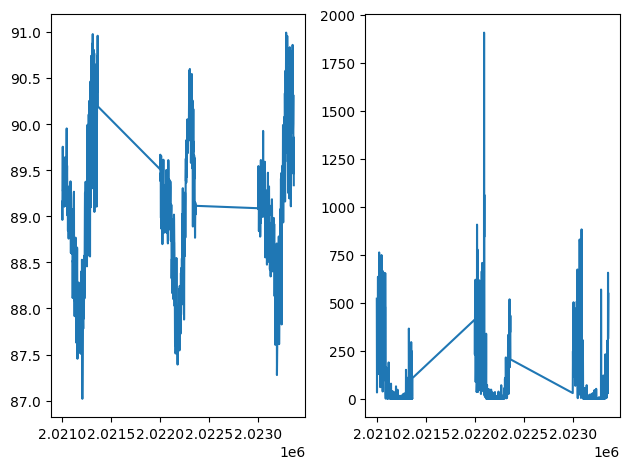

In [95]:
dt = agroeco_series(Temperature_files_path,agvar='Temperature')
dp = agroeco_series(Precipitation_files_path,agvar='Precipitation')

fig,ax = plt.subplots(1,2)
ax[0].plot(np.array(list(dt.keys())) , np.array(list(dt.values())) )
ax[1].plot(np.array(list(dp.keys())) , np.array(list(dp.values())) )
plt.tight_layout()

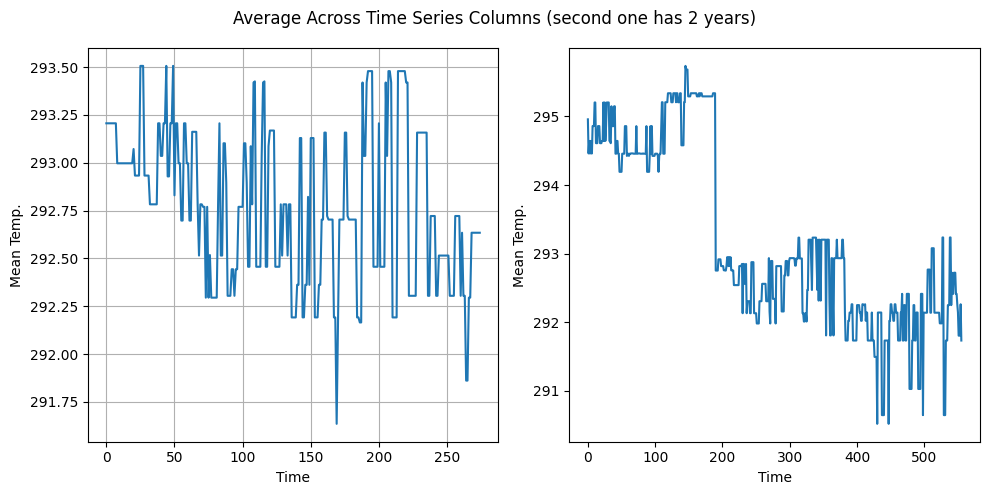

In [96]:
import matplotlib.pyplot as plt

# Compute the mean across columns (axis=1) — at each index (timestamp)
series23 = temp_23.mean(axis=1)
series22 = temp_22.mean(axis=1)
#random_series = temp_23.iloc[3]
# Plot
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(series23)
ax[1].plot(series22)
fig.suptitle('Average Across Time Series Columns (second one has 2 years)')
ax[0].set(xlabel='Time', ylabel='Mean Temp.')
ax[1].set(xlabel='Time', ylabel='Mean Temp.')
ax[0].grid(True)
fig.tight_layout()



In [97]:
cols = [col for col in reduced_df.columns if 'B8' in col or 'B4' in col]
 
temp_df = reduced_df[reduced_df.Intercrop.isin(['Maize','Maize, Pigeon_Pea'])]
temp_df = temp_df[(temp_df[cols] != 65535).all(axis=1)]
temp_df

,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,COASTALBLUE__9,...,Temperature_min,Temperature_max,Precipitation_mean,Precipitation_median,Precipitation_sum,Precipitation_min,Precipitation_max,geometry,Area,n_crops
0,594.0,585.0,640.0,638.0,564.0,625.0,556.0,643.0,445.0,533.0,...,290.061218,299.196442,359.049180,0.0,87608,0,4857,"POLYGON ((3918929.949 -1695251.167, 3918930.50...",0.143631,2
3,443.0,440.0,465.0,446.0,458.0,431.0,482.0,442.0,381.0,689.0,...,289.766388,298.254669,414.565574,0.0,101154,0,7623,"POLYGON ((3883854.262 -1694375.514, 3883853.52...",0.418235,2
4,551.0,448.5,530.5,552.0,516.0,491.5,565.0,431.0,821.5,388.0,...,289.878174,298.989319,368.704918,0.0,89964,0,5588,"POLYGON ((3893938.523 -1700011.161, 3893937.59...",0.358028,1
6,564.0,441.0,524.0,566.0,524.0,525.0,58.0,468.0,893.0,0.0,...,289.766388,298.254669,395.303279,0.0,96454,0,5836,"POLYGON ((3885538.898 -1694423.542, 3885541.68...",0.380792,2
7,709.0,752.0,759.0,959.0,921.0,560.0,838.0,963.0,640.0,681.0,...,290.118347,299.154755,367.446721,0.0,89657,0,5328,"POLYGON ((3885529.638 -1710170.198, 3885531.49...",0.236910,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,500.0,543.0,544.0,520.0,515.0,576.0,592.0,450.0,436.0,373.0,...,288.166290,296.212097,366.844262,0.0,89510,0,6038,"POLYGON ((3948778.375 -1700830.277, 3948774.95...",0.254341,1
817,451.0,428.0,448.0,413.0,412.5,476.0,0.0,717.0,283.0,431.0,...,288.166290,296.212097,366.844262,0.0,89510,0,6038,"POLYGON ((3948977.510 -1701260.879, 3948974.40...",0.229312,1
818,698.5,617.5,573.0,544.5,530.0,494.5,563.0,602.5,396.5,377.0,...,288.166290,296.212097,366.844262,0.0,89510,0,6038,"POLYGON ((3949073.486 -1701217.572, 3949070.43...",0.291689,1
819,537.0,531.0,579.0,570.0,573.0,623.0,549.0,296.0,290.0,360.0,...,288.166290,296.212097,366.844262,0.0,89510,0,6038,"POLYGON ((3949034.344 -1701102.597, 3949034.27...",0.224894,1


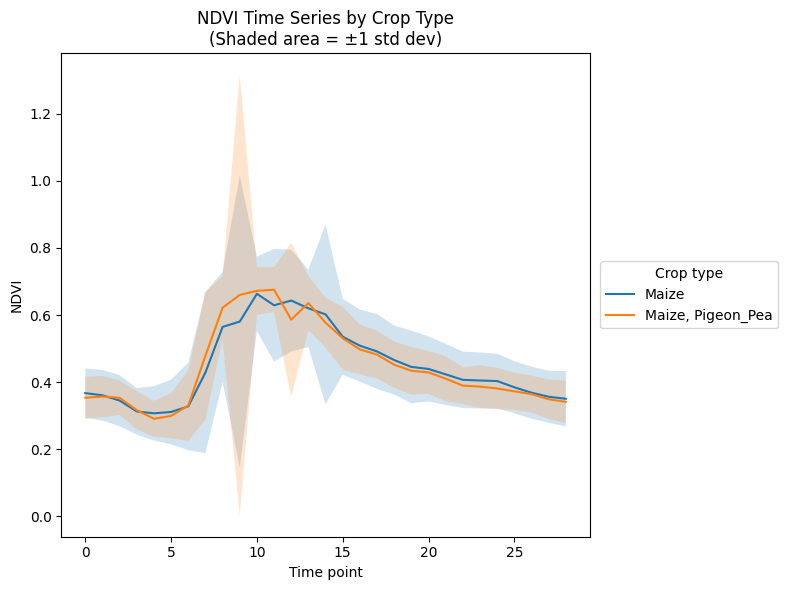

In [106]:
## Plot NDVI timeseries with variance.
## ! you don't need merged df for this - you can work with any 'current_df' option - full_df, reduced_df 

cols = [col for col in reduced_df.columns if 'B8' in col or 'B4' in col]
 
temp_df = reduced_df[reduced_df.Intercrop.isin(['Maize','Maize, Pigeon_Pea'])]
#temp_df = reduced_df[reduced_df.n_crops<3 ]

temp_df = temp_df[(temp_df[cols] != 65535).all(axis=1)]

# Suppose df is your dataframe
# 1. Melt NDVI columns to long format
ndvi_cols = [c for c in temp_df.columns if c.startswith('NDVI__')]
df_long = temp_df.melt(id_vars='Intercrop',
                  value_vars=ndvi_cols,
                  var_name='time',
                  value_name='NDVI')

# 2. Extract numeric time index (optional)
df_long['time_idx'] = df_long['time'].str.extract('NDVI__(\d+)').astype(int)

# 3. Compute mean and variance for each crop type and time
stats = (df_long
         .groupby(['Intercrop', 'time_idx'])
         .agg(mean=('NDVI','mean'),
              var=('NDVI','var'))
         .reset_index())

# 4. Plot
plt.figure(figsize=(8,6))
for ctype, grp in stats.groupby('Intercrop'):
    plt.plot(grp['time_idx'], grp['mean'], label=ctype)
    # variance band (mean ± sqrt(var) is std)
    std = grp['var']**0.5
    plt.fill_between(grp['time_idx'],
                     grp['mean']-std,
                     grp['mean']+std,
                     alpha=0.2)

plt.xlabel('Time point')
plt.ylabel('NDVI')
plt.title('NDVI Time Series by Crop Type\n(Shaded area = ±1 std dev)')
plt.legend(title='Crop type',bbox_to_anchor=(1.02, 0.5), loc='center left', borderaxespad=0)
plt.tight_layout()
plt.show()


In [99]:
1/0

ZeroDivisionError: division by zero

## 3.3 Merged

Includes merged_2022, merged_2023, merged_df ,merged_reduced_2022,merged_reduced_2023, merged_reduced_df 

In [ ]:
merged_reduced_df.lon[0]

NameError: name 'merged_reduced_df' is not defined

In [ ]:
merged_reduced_df

,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,COASTALBLUE__9,...,T_Max_Gradient__B4,Mean__REDEDGE,Median__REDEDGE,Max__REDEDGE,Min__REDEDGE,AUC__REDEDGE,Max_Gradient__REDEDGE,T_Max_Gradient__REDEDGE,lon,lat
0,594.0,585.0,640.0,638.0,564.0,625.0,556.0,643.0,445.0,533.0,...,8,1227.310303,1202.0,1506.0,1040.0,34236.50,451.0,8,3.918956e+06,-1.695237e+06
1,510.0,498.0,538.0,493.0,478.5,533.0,504.0,453.0,396.0,426.0,...,7,1199.689697,1202.0,1369.5,1057.0,33576.00,164.0,10,3.918956e+06,-1.695237e+06
2,526.0,598.0,564.0,586.0,602.0,642.0,593.0,490.0,524.0,460.0,...,7,1412.758667,1426.0,1588.0,1238.0,39461.00,167.0,10,3.918956e+06,-1.695237e+06
3,443.0,440.0,465.0,446.0,458.0,431.0,482.0,442.0,381.0,689.0,...,10,1068.896606,1084.0,1401.0,864.0,30016.00,389.0,9,3.918956e+06,-1.695237e+06
4,551.0,448.5,530.5,552.0,516.0,491.5,565.0,431.0,821.5,388.0,...,13,1127.586182,1192.5,1358.5,0.0,31477.50,1204.5,13,3.918956e+06,-1.695237e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,500.0,543.0,544.0,520.0,515.0,576.0,592.0,450.0,436.0,373.0,...,7,1314.103394,1283.0,1724.0,1132.0,36752.50,419.0,27,3.883838e+06,-1.694336e+06
817,451.0,428.0,448.0,413.0,412.5,476.0,0.0,717.0,283.0,431.0,...,6,1429.275879,1534.5,1833.5,0.0,40064.00,1804.0,6,3.883838e+06,-1.694336e+06
818,698.5,617.5,573.0,544.5,530.0,494.5,563.0,602.5,396.5,377.0,...,7,1422.362061,1502.5,1657.5,1001.0,39678.75,454.0,12,3.883838e+06,-1.694336e+06
819,537.0,531.0,579.0,570.0,573.0,623.0,549.0,296.0,290.0,360.0,...,16,1475.137939,1522.0,1768.0,968.0,41178.00,470.0,16,3.883838e+06,-1.694336e+06


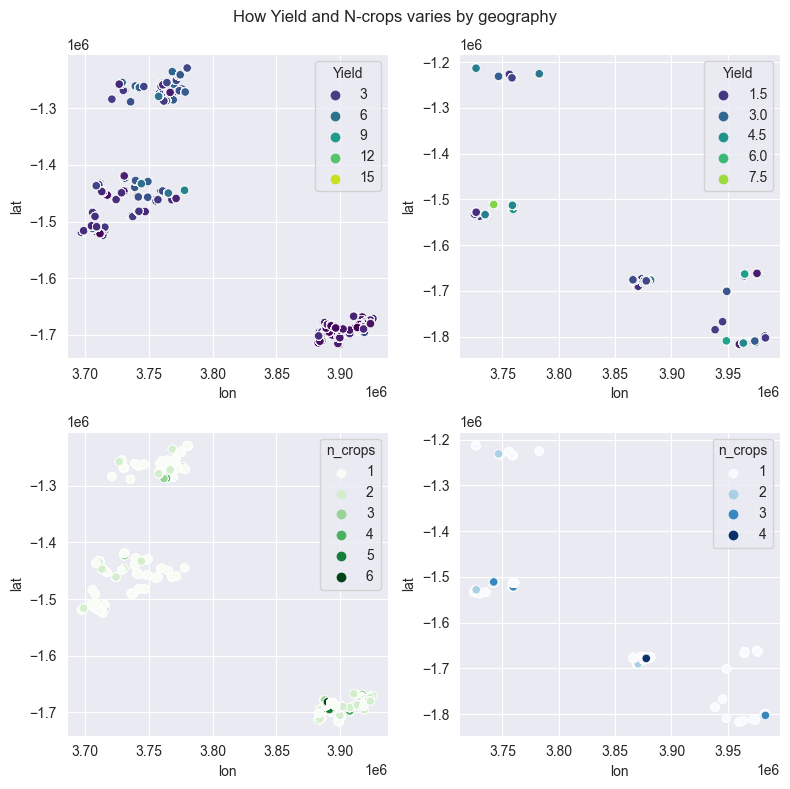

In [ ]:
## Spatial data availability 
sns.set_style("darkgrid")
fig,axes = plt.subplots(2,2,figsize = (8,8))

sns.scatterplot(data = merged_2022 , x = 'lon',y = 'lat',hue = 'Yield',ax=axes[0,0],palette='viridis' )
#axes[0,0].legend(loc='upper left', bbox_to_anchor=(1, 0.5), borderaxespad=0.)
sns.scatterplot(data = merged_2023 , x = 'lon',y = 'lat',hue = 'Yield',ax=axes[0,1],palette='viridis' )
sns.scatterplot(data = merged_2022 , x = 'lon',y = 'lat',hue = 'n_crops',ax=axes[1,0],palette='Greens' )
sns.scatterplot(data = merged_2023 , x = 'lon',y = 'lat',hue = 'n_crops',ax=axes[1,1],palette='Blues' )
fig.suptitle('How Yield and N-crops varies by geography')
plt.tight_layout()
#ax = merged_df.plot.scatter(x = 'lon',y = 'lat',c = 'Yield',colormap='viridis')

In [ ]:
merged_reduced_2022

,COASTALBLUE__0,COASTALBLUE__1,COASTALBLUE__2,COASTALBLUE__3,COASTALBLUE__4,COASTALBLUE__5,COASTALBLUE__6,COASTALBLUE__7,COASTALBLUE__8,COASTALBLUE__9,...,T_Max_Gradient__B4,Mean__REDEDGE,Median__REDEDGE,Max__REDEDGE,Min__REDEDGE,AUC__REDEDGE,Max_Gradient__REDEDGE,T_Max_Gradient__REDEDGE,lon,lat
0,594.0,585.0,640.0,638.0,564.0,625.0,556.0,643.0,445.0,533.0,...,8,1227.310303,1202.0,1506.0,1040.0,34236.50,451.0,8,3.918956e+06,-1.695237e+06
1,510.0,498.0,538.0,493.0,478.5,533.0,504.0,453.0,396.0,426.0,...,7,1199.689697,1202.0,1369.5,1057.0,33576.00,164.0,10,3.918956e+06,-1.695237e+06
2,526.0,598.0,564.0,586.0,602.0,642.0,593.0,490.0,524.0,460.0,...,7,1412.758667,1426.0,1588.0,1238.0,39461.00,167.0,10,3.918956e+06,-1.695237e+06
3,443.0,440.0,465.0,446.0,458.0,431.0,482.0,442.0,381.0,689.0,...,10,1068.896606,1084.0,1401.0,864.0,30016.00,389.0,9,3.918956e+06,-1.695237e+06
4,551.0,448.5,530.5,552.0,516.0,491.5,565.0,431.0,821.5,388.0,...,13,1127.586182,1192.5,1358.5,0.0,31477.50,1204.5,13,3.918956e+06,-1.695237e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,492.0,469.0,567.0,555.0,756.0,486.0,484.0,488.0,344.0,9996.0,...,10,1486.586182,1182.0,9995.0,903.0,41575.00,9029.0,10,3.893403e+06,-1.699763e+06
542,666.0,601.0,645.0,722.0,725.0,704.0,664.0,563.0,646.0,971.0,...,7,1688.034424,1705.0,1917.0,1328.0,47240.50,396.0,7,3.893403e+06,-1.699763e+06
543,629.0,530.0,671.0,671.0,692.0,745.0,679.0,729.0,491.0,788.0,...,8,1654.655151,1644.0,2029.0,1248.0,46285.00,432.0,8,3.893403e+06,-1.699763e+06
544,493.0,453.0,634.0,515.0,694.5,536.5,451.0,473.5,347.5,9997.0,...,9,1765.482788,1543.5,9996.0,1073.0,49560.75,8923.0,10,3.893403e+06,-1.699763e+06


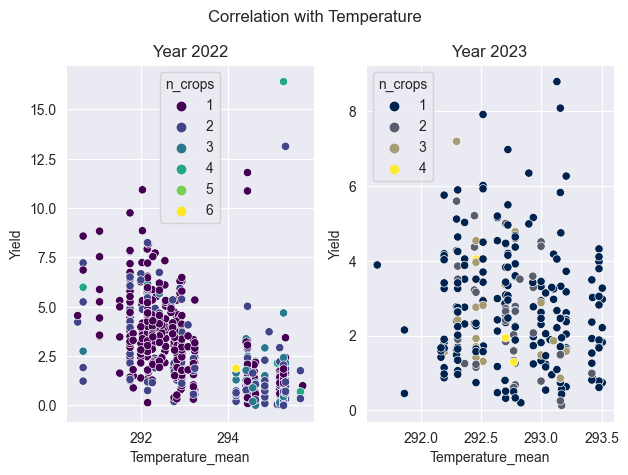

In [ ]:
fig,axes = plt.subplots(1,2)

sns.scatterplot(data = merged_reduced_2022 , x = 'Temperature_mean' , y = 'Yield',hue = 'n_crops',ax = axes[0],palette = 'viridis')
axes[0].set_title('Year 2022')
sns.scatterplot(data = merged_reduced_2023 , x = 'Temperature_mean' , y = 'Yield',hue = 'n_crops',ax = axes[1],palette = 'cividis')
axes[1].set_title('Year 2023')
fig.suptitle('Correlation with Temperature')
plt.tight_layout()

Text(0.5, 1.0, 'N-crops vs Yield')

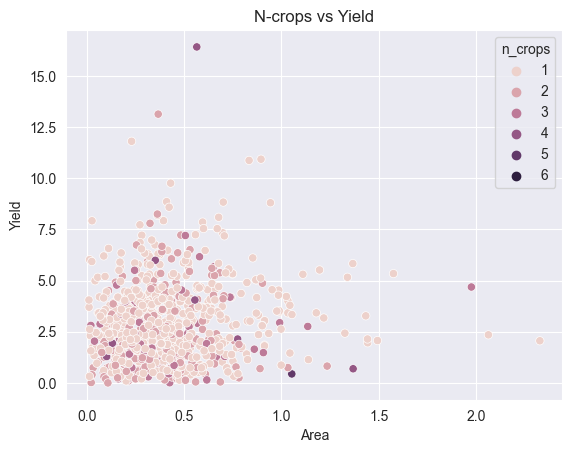

In [ ]:
da = merged_reduced_df[merged_reduced_df['Yield']>0]
sns.scatterplot(data=da,x = 'Area',y='Yield',hue='n_crops')
plt.title('Area vs Yield')

In [ ]:
merged = merged_df[[col for col in merged_df.columns if (not re.search(r'__[0-9]',col))]].select_dtypes(include='number')
merged

,FID,Year,Yield,Field_Id,Temperature_mean,Temperature_median,Temperature_sum,Temperature_min,Temperature_max,Precipitation_mean,...,T_Max_Gradient__B4,Mean__REDEDGE,Median__REDEDGE,Max__REDEDGE,Min__REDEDGE,AUC__REDEDGE,Max_Gradient__REDEDGE,T_Max_Gradient__REDEDGE,lon,lat
0,0,2022,3.731034,0,294.957336,295.199158,71969.593750,290.061218,299.196442,359.049180,...,8,1222.620728,1169.0,1549.0,1033.0,33993.0,503.0,8,3.918956e+06,-1.695237e+06
1,0,2022,3.731034,0,294.957336,295.199158,71969.593750,290.061218,299.196442,359.049180,...,8,1252.172363,1202.0,1572.0,1047.0,34845.0,439.0,8,3.918956e+06,-1.695237e+06
2,0,2022,3.731034,0,294.957336,295.199158,71969.593750,290.061218,299.196442,359.049180,...,17,1280.758667,1234.0,1955.0,954.0,35703.0,617.0,6,3.918956e+06,-1.695237e+06
3,0,2022,3.731034,0,294.957336,295.199158,71969.593750,290.061218,299.196442,359.049180,...,8,1234.000000,1199.0,1595.0,971.0,34337.0,508.0,8,3.918956e+06,-1.695237e+06
4,0,2022,3.731034,0,294.957336,295.199158,71969.593750,290.061218,299.196442,359.049180,...,8,1211.620728,1148.0,1595.0,983.0,33689.0,473.0,2,3.918956e+06,-1.695237e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218688,2450,2023,2.420000,2450,292.634125,292.964752,71402.726562,288.166290,296.212097,366.844262,...,6,1614.551758,1611.0,2004.0,1280.0,44965.0,573.0,14,3.949013e+06,-1.701089e+06
218689,2450,2023,2.420000,2450,292.634125,292.964752,71402.726562,288.166290,296.212097,366.844262,...,6,1642.172363,1606.0,2060.0,1282.0,45723.5,565.0,14,3.949013e+06,-1.701089e+06
218690,2450,2023,2.420000,2450,292.634125,292.964752,71402.726562,288.166290,296.212097,366.844262,...,6,1658.310303,1601.0,2135.0,1310.0,46148.0,570.0,6,3.949013e+06,-1.701089e+06
218691,2450,2023,2.420000,2450,292.634125,292.964752,71402.726562,288.166290,296.212097,366.844262,...,6,1662.689697,1597.0,2201.0,1307.0,46263.5,589.0,14,3.949013e+06,-1.701089e+06


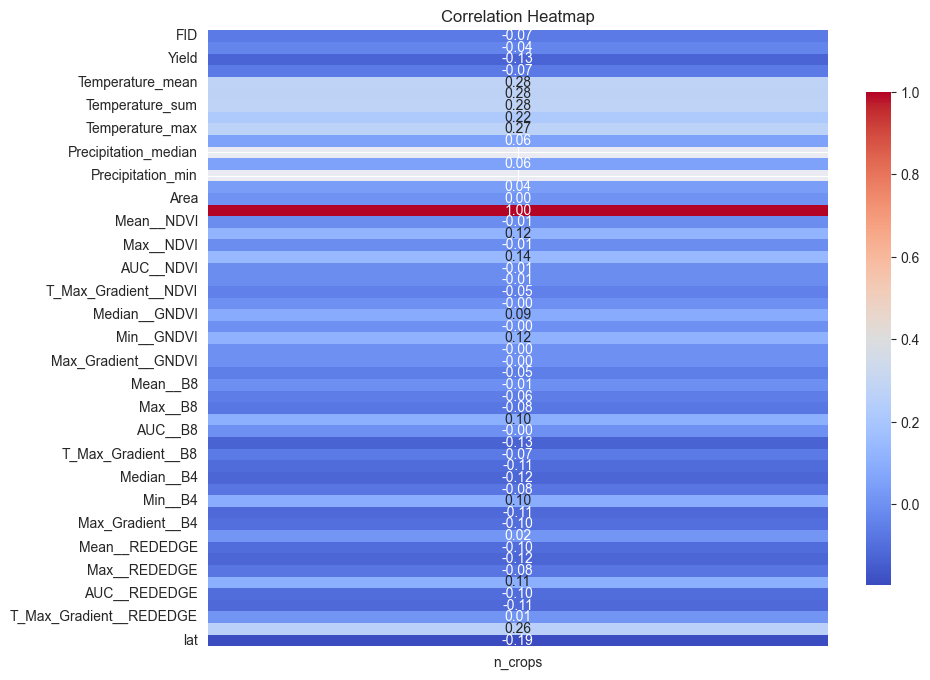

In [ ]:
corr = merged.corr()
corr = corr[['n_crops']]
# 2. Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# 3. Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=False, cbar_kws={"shrink": .8})

# 4. Show plot
plt.title("Correlation Heatmap")
plt.show()

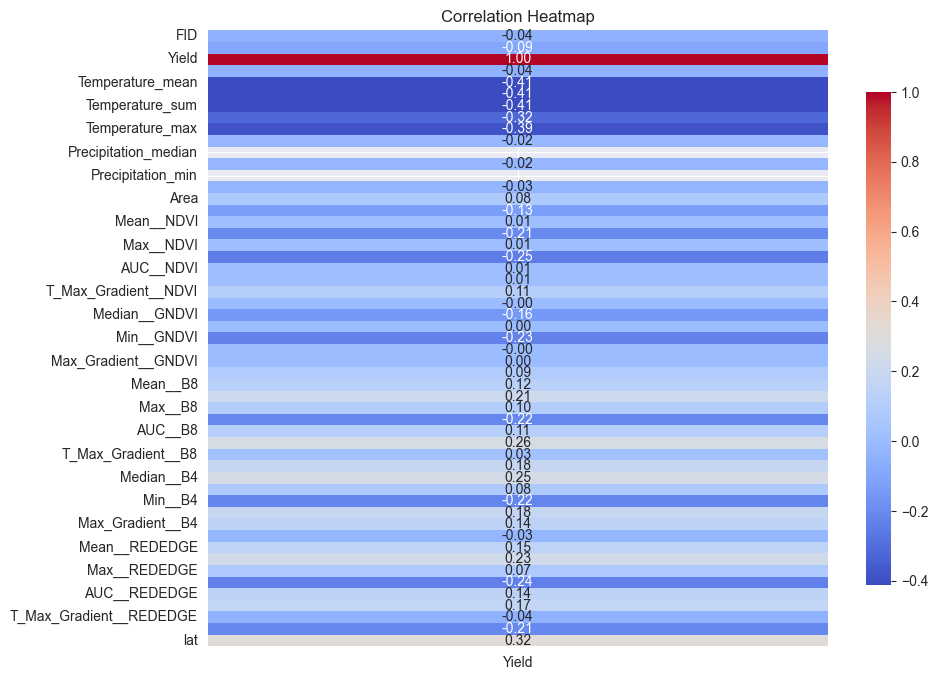

In [ ]:
corr = merged.corr()
corr = corr[['Yield']]
# 2. Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# 3. Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=False, cbar_kws={"shrink": .8})

# 4. Show plot
plt.title("Correlation Heatmap")
plt.show()

# 4. Feature Selection

In [ ]:
def IFE(data,target,by='covar',model=None,correlation_threshold=0.4,verbose=False,plot=False,waitforinput=False):
  '''
  Iterative Feature Selection.
  by = model or var
  IFE(by='var',correlation_threshold=0.4,verbose=True,plot=True,waitforinput=True)
  '''


  selected_features = []
  while data.shape[1] > 1:
    print("Shape is", data.shape[1])
    input() if waitforinput else -1
    if(by=='var'):
      feature_variances = data.var()
      selected_feature = feature_variances.idxmax()
    elif by == 'covar':
      covariances = data.cov()[target].drop(target)
      selected_feature = covariances.abs().idxmax()

    elif(by=='model'):
      model.fit(data,target)
      selected_feature = data.columns[model.feature_importances_.argmax()]
    else:
      raise Exception('Unrecognized value for by parameter')

    selected_features.append(selected_feature)
    print(selected_feature ,"Selected") if verbose else -1

    correlated_features = data.corr()[selected_feature].abs()
    plt.plot(correlated_features) if plot else -1
    plt.show() if plot else -1
    correlated_features = correlated_features[correlated_features > correlation_threshold].index

    print("Correlated Features are ",correlated_features) if verbose else -1
    if(len(correlated_features) < 1): 
      break
    data = data.drop(correlated_features, axis=1)

  return selected_features


In [ ]:
current_df.Intercrop.value_counts()

Intercrop
Maize                                                   147664
Maize, Pigeon_Pea                                        11347
Maize, Pumpkin                                           10543
Maize, Beans                                              7992
Maize, Soybean                                            7265
Maize, Groundnut                                          4327
Maize, Groundnut, Soybean                                 3025
Maize, Beans, Pumpkin                                     2355
Maize, Pigeon_Pea, Pumpkin                                1965
Maize, Pigeon_Pea, Sorghum                                1837
Maize, Sorghum                                            1583
Maize, Pigeon_Pea, Groundnut                              1569
Maize, Sweet_Potato, Soybean                              1554
Maize, Sunflower                                          1350
Maize, Cowpea                                             1217
Maize, Groundnut, Sweet_Potato               

In [ ]:
current_df = merged_df
fid = current_df.FID
columns_to_drop = [  'geometry','Main_Ct' ,'Intercrop' , 'Other_Ct' ,'Source','Src_File','Field_Id' ,'FID', 'Year'] 
# Removing year because when dealing with only maize vs maize_pigeonpea , Year only have 1 class.
columns_to_drop = columns_to_drop + [col for col in current_df.columns if 'ALPHA' in col]
current_df = current_df.drop(columns = columns_to_drop)
selected_features = IFE(data = current_df.copy() , target = 'Yield' , by = 'covar' ,correlation_threshold = 0.4, verbose=True)


Shape is 340
lat Selected
Correlated Features are  Index(['Temperature_mean', 'Temperature_median', 'Temperature_sum',
       'Temperature_max', 'lon', 'lat'],
      dtype='object')
Shape is 334
AUC__B4 Selected
Correlated Features are  Index(['COASTALBLUE__0', 'COASTALBLUE__1', 'COASTALBLUE__2', 'COASTALBLUE__3',
       'COASTALBLUE__4', 'COASTALBLUE__5', 'COASTALBLUE__16',
       'COASTALBLUE__17', 'COASTALBLUE__18', 'COASTALBLUE__20',
       ...
       'Median__B8', 'AUC__B8', 'Mean__B4', 'Median__B4', 'Max__B4', 'AUC__B4',
       'Mean__REDEDGE', 'Median__REDEDGE', 'Max__REDEDGE', 'AUC__REDEDGE'],
      dtype='object', length=218)
Shape is 116
Max_Gradient__B8 Selected
Correlated Features are  Index(['COASTALBLUE__9', 'B2__9', 'GREENI__9', 'B3__9', 'YELLOW__9', 'B4__9',
       'REDEDGE__9', 'B8__9', 'GNDVI__9', 'Min__NDVI', 'Min__GNDVI', 'Max__B8',
       'Min__B8', 'Max_Gradient__B8', 'Min__B4', 'Max_Gradient__B4',
       'Min__REDEDGE', 'Max_Gradient__REDEDGE'],
      dtype='obje

In [ ]:
selected_features

['lat',
 'AUC__B4',
 'Max_Gradient__B8',
 'Precipitation_sum',
 'B8__7',
 'B8__10',
 'REDEDGE__11',
 'B8__13',
 'B8__8',
 'REDEDGE__10',
 'B8__16',
 'REDEDGE__12',
 'B8__19',
 'Max_Gradient__NDVI',
 'B8__6',
 'B8__14',
 'COASTALBLUE__15',
 'COASTALBLUE__14',
 'COASTALBLUE__13',
 'NDVI__12',
 'NDVI__8',
 'NDVI__11',
 'NDVI__6',
 'NDVI__3',
 'NDVI__13',
 'NDVI__19',
 'T_Max_Gradient__NDVI',
 'T_Max_Gradient__REDEDGE',
 'AUC__GNDVI',
 'NDVI__5',
 'n_crops',
 'NDVI__10',
 'T_Max_Gradient__B8',
 'Area',
 'NDVI__20',
 'NDVI__15',
 'GNDVI__12',
 'NDVI__14',
 'Precipitation_median']

In [ ]:
selected_features_backup = selected_features 
selected_features=selected_features_backup[:15] + ['Temperature_mean']

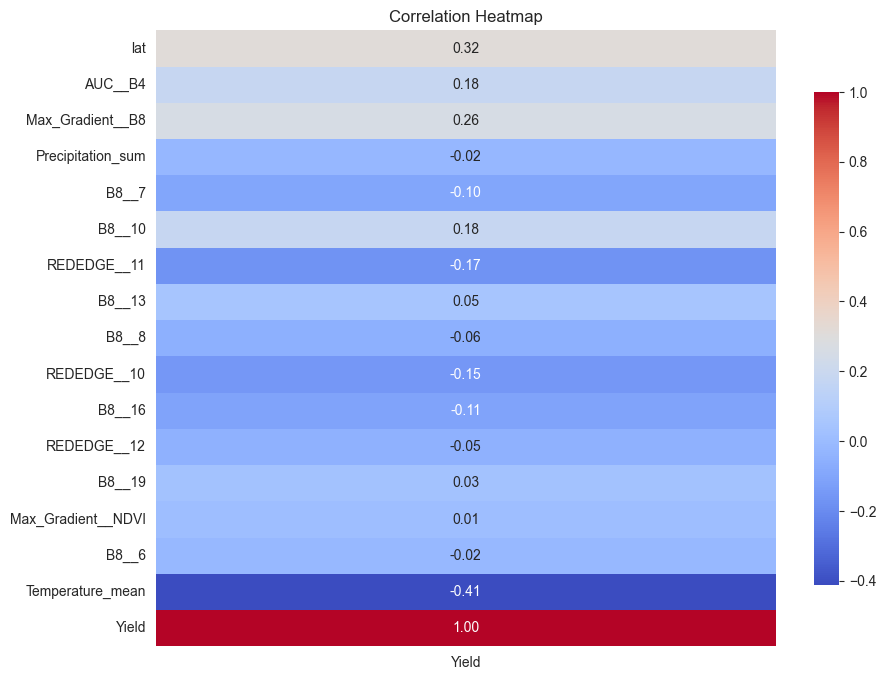

In [ ]:
corr = current_df[selected_features+['Yield']].corr()
corr = corr[['Yield']]
# 2. Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# 3. Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=False, cbar_kws={"shrink": .8})

# 4. Show plot
plt.title("Correlation Heatmap")
plt.show()

# 5. Machine Learning

## 5.1 Predicting Yield

In [ ]:
X = current_df[selected_features+['n_crops','T_Max_Gradient__NDVI']]
y  = current_df.Yield

unique_fids = fid.unique() 

# Train-test split
fid_train, fid_test = train_test_split(unique_fids , test_size = 0.2) 
X_train = X[fid.isin(fid_train)]
X_test = X[fid.isin(fid_test)] 

y_train = y[fid.isin(fid_train)]
y_test = y[fid.isin(fid_test)]


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Models
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42)
}
results = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'model': model, 'mse': mse, 'r2': r2, 'y_pred': y_pred}


In [ ]:
results

{'LinearRegression': {'model': LinearRegression(),
  'mse': 3.170338594635545,
  'r2': 0.28706702593396705,
  'y_pred': array([1.75311037, 1.47001092, 1.4878823 , ..., 3.30639516, 3.3796179 ,
         3.25474276])},
 'Ridge': {'model': Ridge(),
  'mse': 3.170337891029408,
  'r2': 0.2870671841580812,
  'y_pred': array([1.75311515, 1.47001451, 1.48788624, ..., 3.30638978, 3.37961292,
         3.25473705])},
 'RandomForest': {'model': RandomForestRegressor(random_state=42),
  'mse': 3.373887269085145,
  'r2': 0.24129381985178366,
  'y_pred': array([2.41442586, 2.4005954 , 2.35705   , ..., 2.96874023, 3.0029977 ,
         2.9524046 ])},
 'DecisionTree': {'model': DecisionTreeRegressor(random_state=42),
  'mse': 4.072528974777004,
  'r2': 0.08418608697799523,
  'y_pred': array([2.9454023 , 2.9454023 , 2.9454023 , ..., 4.36178161, 4.36178161,
         4.36178161])}}

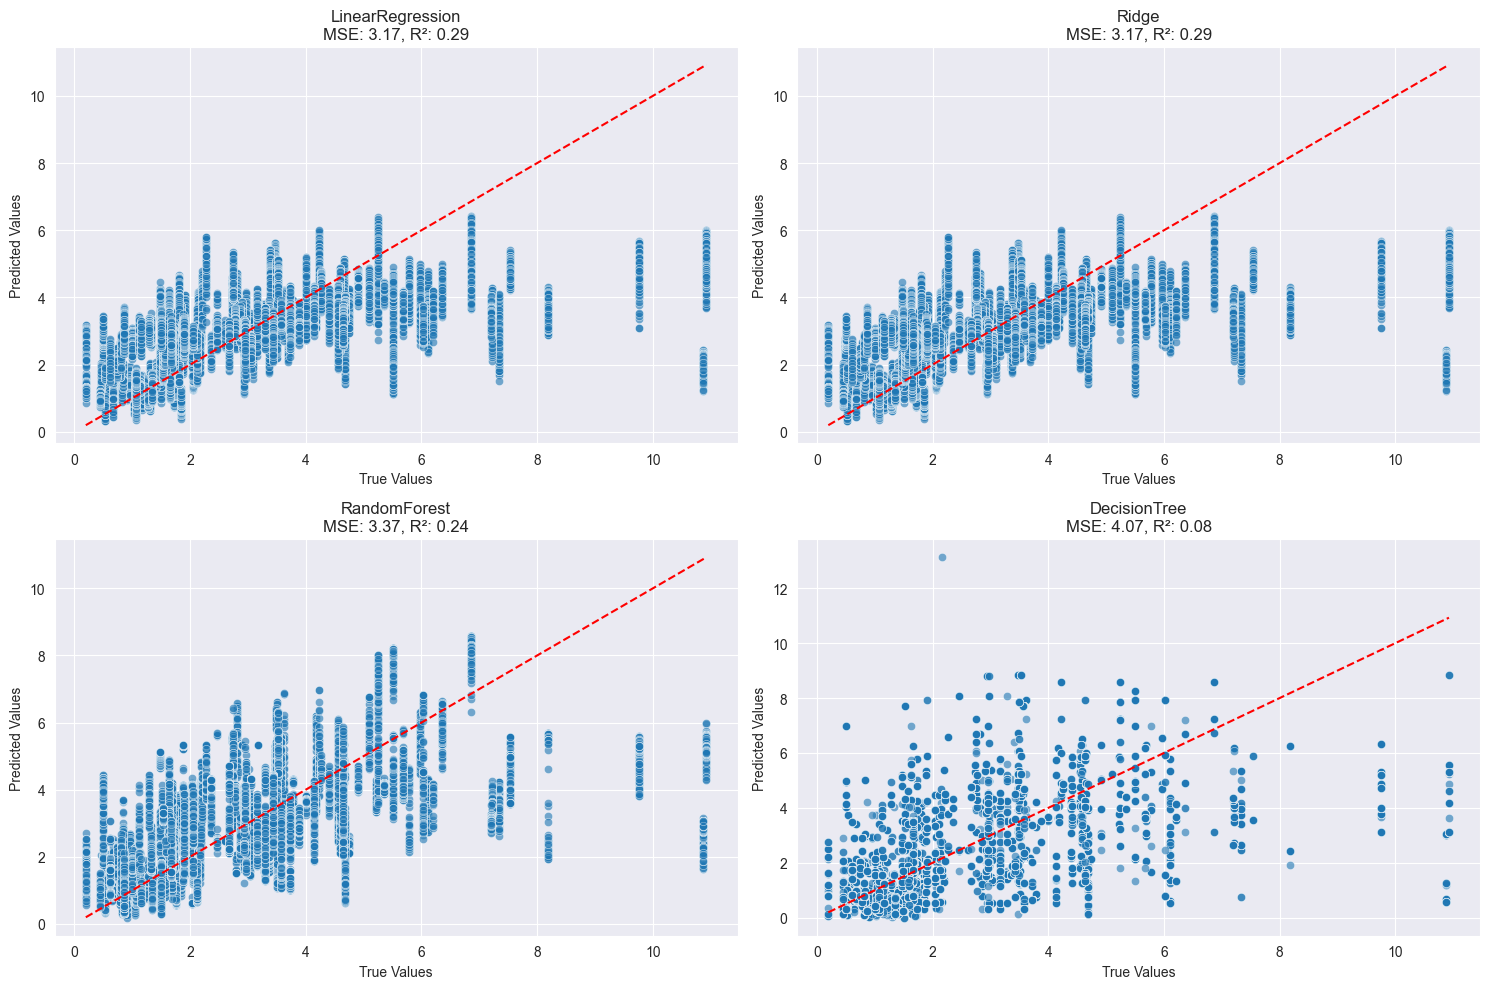

In [ ]:
# Plotting results
plt.figure(figsize=(15, 10))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=y_test, y=res['y_pred'], alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name}\nMSE: {res["mse"]:.2f}, R²: {res["r2"]:.2f}')
plt.tight_layout()
plt.show()


<Axes: xlabel='AUC__B4', ylabel='Yield'>

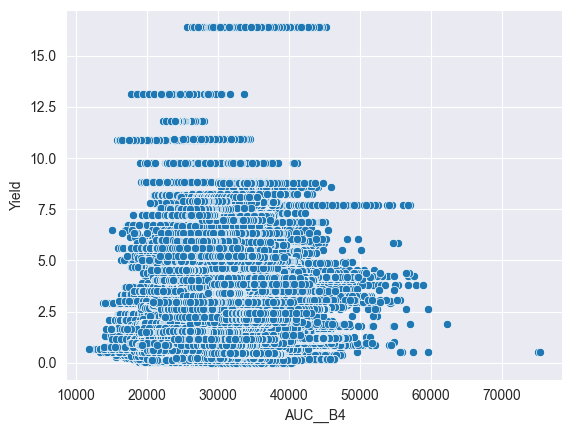

In [ ]:
sns.scatterplot(data = current_df , x = 'AUC__B4' ,y = 'Yield')

## 5.2 Predicting intercropping